In [70]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns

In [71]:
#load train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [72]:
#use 3σ to find outliers
def three_sigma(data_series):
    rule = (data_series.mean() - 3 * data_series.std() > data_series) | (data_series.mean() + 3 * data_series.std() < data_series)
    index = np.arange(data_series.shape[0])[rule]
    outliers = data_series.iloc[index]
    return outliers.tolist()
# data_series = pd.Series(data)
outliers = three_sigma(train['playtime_forever'])
print(len(outliers))
print(outliers)

7
[56.66666666666666, 49.38333333333333, 51.28333333333333, 92.63333333333334, 78.7, 113.8, 63.8]


In [73]:
#delete outliers
train_out = train.sort_values(by = 'playtime_forever', ascending = False)
# train_out[0:6]
train = train_out.drop(train_out.head(7).index)
train.head(2)

,id,playtime_forever,is_free,price,genres,categories,tags,purchase_date,release_date,total_positive_reviews,total_negative_reviews
90,90,32.766667,False,9900.0,RPG,"Single-player,Steam Achievements,Full controll...","Open World,Post-apocalyptic,Exploration,Single...","Dec 7, 2017","9 Nov, 2015",68660.0,27235.0
221,221,31.983333,False,5000.0,"Indie,RPG","Single-player,Steam Achievements,Steam Trading...","RPG,Turn-Based,Turn-Based Combat,Indie,Choices...","Mar 3, 2017","14 Oct, 2015",1651.0,382.0


In [74]:
#convert to list
train.genres = train['genres'].str.split(',', expand=False)
train.genres.head(2)

90            [RPG]
221    [Indie, RPG]
Name: genres, dtype: object

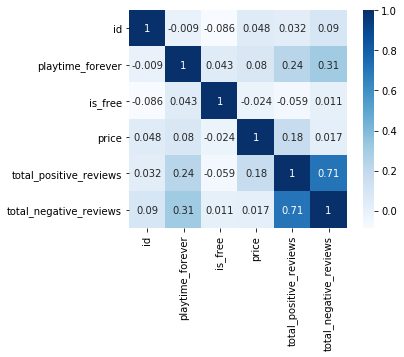

In [75]:
sns.heatmap(train.corr(), annot=True, vmax=1, square=True, cmap="Blues")
#find the strong relation: price and total_positive_reviews

In [76]:
def countN(column):
    count = dict()
    for row in column:
        for ele in row:
            if ele in count:
                count[ele] += 1
            else:
                count[ele] = 1
    return count

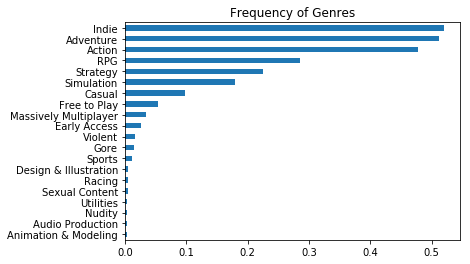

In [77]:
#frequency of genres
genres = pd.Series(countN(train.genres)).sort_values()
genres_avg = genres/len(train)
genres_avg.plot(kind='barh', title='Frequency of Genres')

In [78]:
#convert to list
train.categories = train['categories'].str.split(',', expand=False)

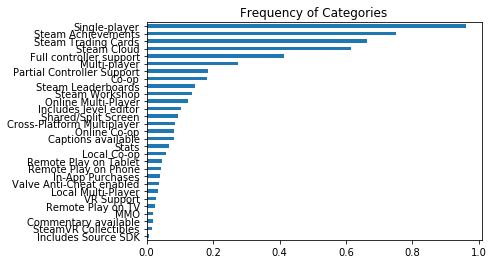

In [79]:
#frequency of categories
categories = pd.Series(countN(train.categories)).sort_values()
categories_avg = categories/len(train)
categories_avg.plot(kind='barh', title='Frequency of Categories')

In [80]:
#for each game, use a binary array to represent genres, categories
def binary(wordlist0, wordlist):
    binary = []
    for word in wordlist0.index:
        if word in wordlist:
            binary.append(1)
        else:
            binary.append(0)
    return binary

train['genres_bin'] = [binary(genres, x) for x in train.genres]
train['categories_bin'] = [binary(categories, x) for x in train.categories]

In [81]:
from scipy import spatial
#define a function to calculate the angle between two games(dis-similarity)
def angle(game1, game2):
    dis_sim = 0
    iterlist = [[game1.genres_bin, game2.genres_bin],
               [game1.categories_bin, game2.categories_bin]]
    for g1, g2 in iterlist:
        if (1 not in g1) or (1 not in g2):
            dis = 1
        else:
            dis = spatial.distance.cosine(g1, g2)
        dis_sim += dis
    return dis_sim

In [82]:
#for example, dis-similarity between game0 and game1, game0 and game2
print(angle(train.iloc[0], train.iloc[1]))
print(angle(train.iloc[0], train.iloc[2]))

0.5428932188134525
1.3027864045000421


In [83]:
#to predict the playtime in the future
#for a game in the future, calculate all the angles betweeen all the other games,
#and choose top5 angles, calculate the average as the predicted time.
def predictor(new_game):
    game_bin = pd.Series()
    game_bin['genres_bin'] = binary(genres, new_game['genres'])
    game_bin['categories_bin'] = binary(categories, new_game['categories'])
    time = train.copy()
    time['angle'] = [angle(time.iloc[i], game_bin) for i in range(len(time))]
    time = time.sort_values('angle')
    time_avg = np.mean(time[0:5])
    return time_avg

In [84]:
#for example:
gamenum1 = {'genres': ['Action', 'Adventure'], 'categories': ['Single-player', 'Full controller support']}
predictor(gamenum1)

id                          214.400000
playtime_forever              4.666667
is_free                       0.000000
price                     10320.000000
total_positive_reviews    73578.200000
total_negative_reviews    25950.800000
angle                         0.292893
dtype: float64

In [85]:
test.genres = test['genres'].str.split(',', expand=False)
test.categories = test['categories'].str.split(',', expand=False)

In [86]:
d = {}
for idx in range(90):
    d['genres'] = test.genres[idx]
    d['categories'] = test.categories[idx]
    print(predictor(d)['playtime_forever'])

4.666666666666667
2.1133333333333333
0.38
0.5266666666666666
3.6799999999999997
0.8866666666666667
5.1
1.6433333333333333
9.023333333333333
0.9666666666666668
2.91
0.13999999999999999
0.8433333333333334
1.0866666666666664
2.6933333333333334
0.8566666666666667
1.7233333333333334
1.01
1.2933333333333334
5.76
0.0
8.5
0.2033333333333333
0.36666666666666664
0.4666666666666666
0.12333333333333334
1.92
0.45333333333333325
1.1533333333333335
0.15
1.5266666666666666
1.9466666666666665
0.7533333333333333
0.45333333333333325
8.713333333333333
2.5366666666666666
0.19
6.786666666666667
0.8433333333333334
0.09666666666666665
0.37
0.64
0.7766666666666667
0.8433333333333334
0.8800000000000001
0.12333333333333334
0.11000000000000001
0.09333333333333334
0.0
1.27
0.5266666666666666
0.8700000000000001
0.5266666666666666
0.11333333333333333
0.9466666666666667
0.3433333333333334
0.45333333333333325
0.49000000000000005
0.0
1.5699999999999998
0.22000000000000003
4.673333333333334
0.6066666666666667
7.07333333